In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import statsmodels.api as sm
import prophet
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
prophet.Prophet()

In [3]:
df = pd.read_csv('variable_selected_county_dataset.csv', index_col=0)

In [4]:
data = pd.read_csv('variable_selected_county_dataset.csv').iloc[:, 1:]

In [5]:
def difference(df):
    df['incremental_cases'] = df['incremental_cases'].diff().fillna(df['incremental_cases'])
    return df

chicago = data[data['entity'] == 'California-San Diego'].loc[:, ['date', 'incremental_cases']]
chicago['incremental_cases'] = chicago['incremental_cases'].astype('int')
chicago['date'] = pd.to_datetime(chicago['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = chicago.iloc[:230, :]
test = chicago.iloc[230:, :]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

stationary_test(train.incremental_cases)

(-1.7066438842169693, 0.4276926398957317)

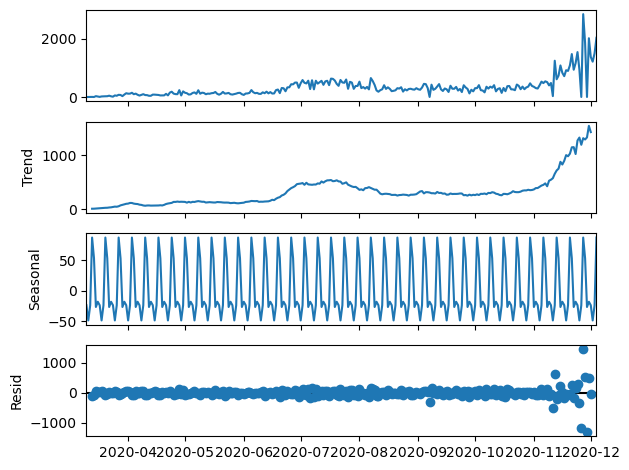

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

analysis = chicago.set_index('date').copy()


decompose_result_mult = seasonal_decompose(analysis)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

In [7]:
for x in decompose_result_mult.seasonal:
    print(x)

-23.701904374836715
-48.7276105321218
-23.781664586175857
87.45223096350917
53.48230615147909
-26.67182918686678
-18.05152843498708
-23.701904374836715
-48.7276105321218
-23.781664586175857
87.45223096350917
53.48230615147909
-26.67182918686678
-18.05152843498708
-23.701904374836715
-48.7276105321218
-23.781664586175857
87.45223096350917
53.48230615147909
-26.67182918686678
-18.05152843498708
-23.701904374836715
-48.7276105321218
-23.781664586175857
87.45223096350917
53.48230615147909
-26.67182918686678
-18.05152843498708
-23.701904374836715
-48.7276105321218
-23.781664586175857
87.45223096350917
53.48230615147909
-26.67182918686678
-18.05152843498708
-23.701904374836715
-48.7276105321218
-23.781664586175857
87.45223096350917
53.48230615147909
-26.67182918686678
-18.05152843498708
-23.701904374836715
-48.7276105321218
-23.781664586175857
87.45223096350917
53.48230615147909
-26.67182918686678
-18.05152843498708
-23.701904374836715
-48.7276105321218
-23.781664586175857
87.45223096350917


In [8]:
arimaModel = chicago[['date', 'incremental_cases']]
arimaModel.rename(columns={"date": "ds", "incremental_cases": "y"}, inplace=True)
train = arimaModel.head(int(0.85*len(arimaModel))+1)
test = arimaModel.tail(int(0.15*len(arimaModel)))

21:00:56 - cmdstanpy - INFO - Chain [1] start processing
21:00:56 - cmdstanpy - INFO - Chain [1] done processing


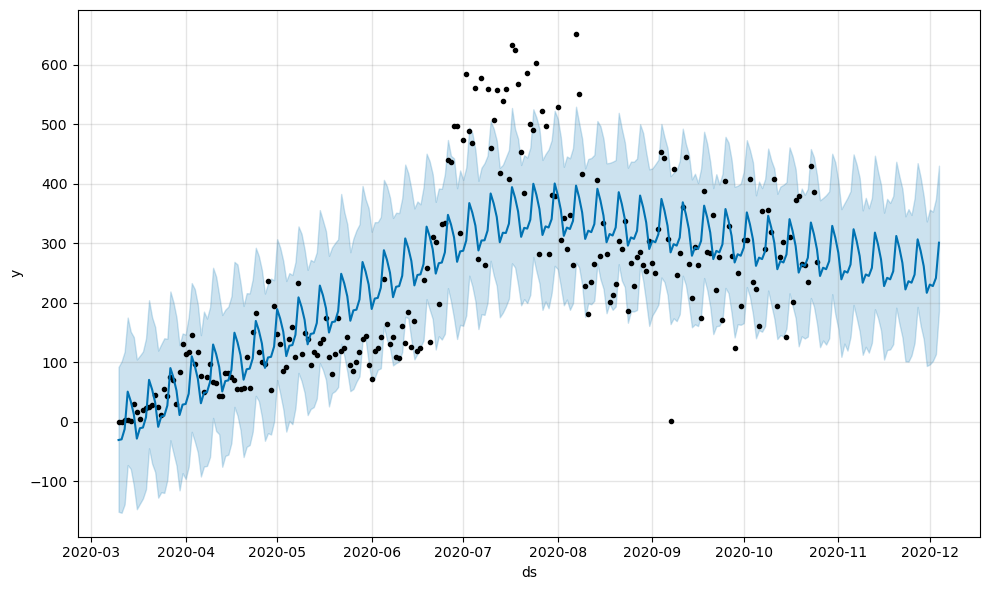

In [9]:
baseModel = prophet.Prophet().fit(train)
future = baseModel.make_future_dataframe(periods=40)
forecast = baseModel.predict(future)
baseModel.plot(forecast);

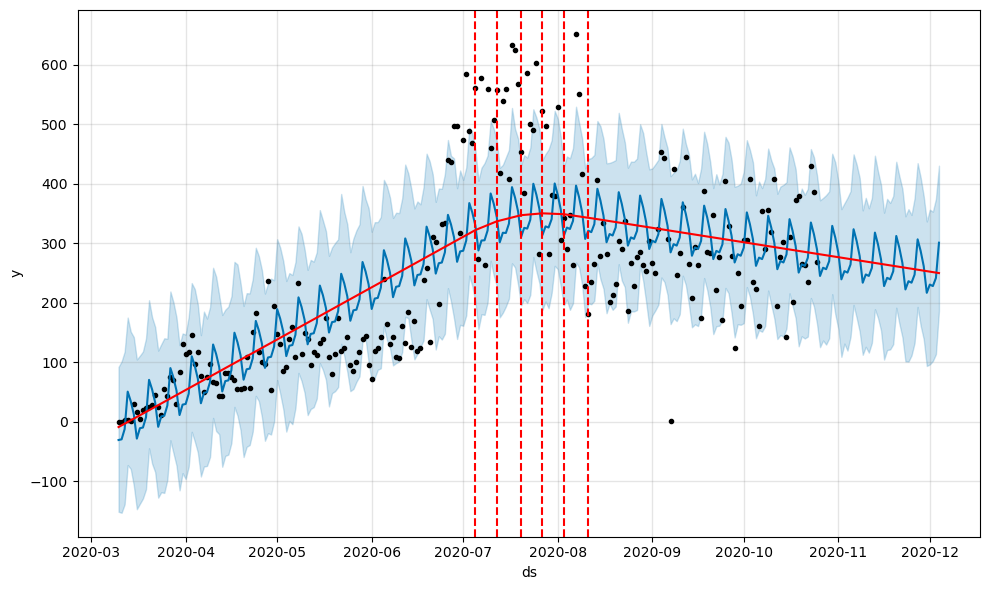

In [10]:
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = baseModel.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), baseModel, forecast)

In [11]:
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

In [12]:
dfToUse = df[df['entity'] == 'California-San Diego']
dfToUse.rename(columns={"date": "ds", "incremental_cases": "y"}, inplace=True)
foo = dfToUse.copy().drop(labels=['ds','entity','y','cases'],axis=1)
non_floats = []
for col in foo:
    if foo[col].dtypes == "float64":
        non_floats.append(col)
foo.drop(labels=non_floats,axis=1,inplace=True)
    
dummyDF = pd.get_dummies(dfToUse, columns=foo.columns.tolist())

In [13]:
toDrop = dummyDF.columns[dummyDF.nunique() == 1].tolist()
#toDrop.pop()
#dfToUse.drop(labels=toDrop, axis=1, inplace=True)
dummyDF.drop(labels=toDrop, axis=1, inplace=True)

In [14]:
dummyDF.ds

192     2020-03-10
203     2020-03-11
215     2020-03-12
227     2020-03-13
239     2020-03-14
           ...    
3371    2020-11-30
3383    2020-12-01
3395    2020-12-02
3407    2020-12-03
3419    2020-12-04
Name: ds, Length: 270, dtype: object

In [15]:
train = dummyDF[dummyDF['ds'] < '2020-10-26'].sort_values(by=['ds']).reset_index().drop(labels=['index'],axis=1)
test = dummyDF[dummyDF['ds'] >= '2020-10-26']

In [16]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

#train.reset_index(inplace=True)

n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

changepoint_prior_scale = [0.001, 0.01, 0.1, 0.5]
seasonality_prior_scale =  [0.01, 0.1, 1.0, 10.0]
holidays_prior_scale = [0.01, 0.1, 1.0, 10.0]
seasonality_mode = ['additive', 'multiplicative']

best_score, best_cfg = float("inf"), None
    
for h in holidays_prior_scale:
    for c in changepoint_prior_scale:
        for s in seasonality_prior_scale:
            for m in seasonality_mode:
                avg = 0
                print((h,c,s,m))
                for train_index, val_index in tscv.split(train):
                    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
                    val_data.fillna(0, inplace=True)
                    train_data.fillna(0, inplace=True)
                    model=prophet.Prophet(holidays=events, holidays_prior_scale=h, changepoint_prior_scale=c, seasonality_prior_scale=s,
                                         seasonality_mode = m,yearly_seasonality=True, weekly_seasonality=True)
                    for ii in train_data.columns:
                        if ii == 'index':
                            continue
                        if ii == 'ds':
                            continue
                        if ii == 'cases':
                            continue
                        if ii == 'y':
                            continue
                        model.add_regressor(ii)
                    model.add_country_holidays(country_name='US')
                    model.fit(train_data)
                    #future = model.make_future_dataframe(periods=val_data.shape[0])
                    #future = future[future['ds'] > train_data.ds.iloc[-1]]
                    forecast = model.predict(val_data)
                    mse = mean_squared_error(val_data.y, forecast.yhat)
                    avg += mse
                if avg < best_score:
                    best_score, best_cfg = avg, (h,c,s,m)

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

21:00:56 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.001, 0.01, 'additive')


21:00:57 - cmdstanpy - INFO - Chain [1] done processing
21:00:57 - cmdstanpy - INFO - Chain [1] start processing
21:00:57 - cmdstanpy - INFO - Chain [1] done processing
21:00:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:00:57 - cmdstanpy - INFO - Chain [1] start processing
21:00:57 - cmdstanpy - INFO - Chain [1] done processing
21:00:57 - cmdstanpy - INFO - Chain [1] start processing
21:00:57 - cmdstanpy - INFO - Chain [1] done processing
21:00:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:00:57 - cmdstanpy - INFO - Chain [1] start processing
21:00:59 - cmdstanpy - INFO - Chain [1] done processing
21:00:59 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.001, 0.01, 'multiplicative')


21:01:00 - cmdstanpy - INFO - Chain [1] done processing
21:01:00 - cmdstanpy - INFO - Chain [1] start processing
21:01:00 - cmdstanpy - INFO - Chain [1] done processing
21:01:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:01:00 - cmdstanpy - INFO - Chain [1] start processing
21:01:00 - cmdstanpy - INFO - Chain [1] done processing
21:01:00 - cmdstanpy - INFO - Chain [1] start processing
21:01:00 - cmdstanpy - INFO - Chain [1] done processing
21:01:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:01:00 - cmdstanpy - INFO - Chain [1] start processing
21:01:01 - cmdstanpy - INFO - Chain [1] done processing
21:01:01 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.001, 0.1, 'additive')


21:01:01 - cmdstanpy - INFO - Chain [1] done processing
21:01:01 - cmdstanpy - INFO - Chain [1] start processing
21:01:01 - cmdstanpy - INFO - Chain [1] done processing
21:01:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:01:01 - cmdstanpy - INFO - Chain [1] start processing
21:01:02 - cmdstanpy - INFO - Chain [1] done processing
21:01:02 - cmdstanpy - INFO - Chain [1] start processing
21:01:02 - cmdstanpy - INFO - Chain [1] done processing
21:01:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:01:02 - cmdstanpy - INFO - Chain [1] start processing
21:01:03 - cmdstanpy - INFO - Chain [1] done processing
21:01:03 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.001, 0.1, 'multiplicative')


21:01:03 - cmdstanpy - INFO - Chain [1] done processing
21:01:03 - cmdstanpy - INFO - Chain [1] start processing
21:01:03 - cmdstanpy - INFO - Chain [1] done processing
21:01:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:01:03 - cmdstanpy - INFO - Chain [1] start processing
21:01:04 - cmdstanpy - INFO - Chain [1] done processing
21:01:04 - cmdstanpy - INFO - Chain [1] start processing
21:01:04 - cmdstanpy - INFO - Chain [1] done processing
21:01:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:01:04 - cmdstanpy - INFO - Chain [1] start processing
21:01:05 - cmdstanpy - INFO - Chain [1] done processing
21:01:05 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.001, 1.0, 'additive')


21:01:05 - cmdstanpy - INFO - Chain [1] done processing
21:01:05 - cmdstanpy - INFO - Chain [1] start processing
21:01:05 - cmdstanpy - INFO - Chain [1] done processing
21:01:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:01:05 - cmdstanpy - INFO - Chain [1] start processing
21:01:07 - cmdstanpy - INFO - Chain [1] done processing
21:01:07 - cmdstanpy - INFO - Chain [1] start processing
21:01:07 - cmdstanpy - INFO - Chain [1] done processing
21:01:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:01:07 - cmdstanpy - INFO - Chain [1] start processing
21:01:07 - cmdstanpy - INFO - Chain [1] done processing
21:01:07 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.001, 1.0, 'multiplicative')


21:01:22 - cmdstanpy - INFO - Chain [1] done processing
21:01:22 - cmdstanpy - INFO - Chain [1] start processing
21:01:22 - cmdstanpy - INFO - Chain [1] done processing
21:01:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:01:22 - cmdstanpy - INFO - Chain [1] start processing
21:01:24 - cmdstanpy - INFO - Chain [1] done processing
21:01:24 - cmdstanpy - INFO - Chain [1] start processing
21:01:24 - cmdstanpy - INFO - Chain [1] done processing
21:01:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:01:24 - cmdstanpy - INFO - Chain [1] start processing
21:01:36 - cmdstanpy - INFO - Chain [1] done processing
21:01:37 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.001, 10.0, 'additive')


21:01:37 - cmdstanpy - INFO - Chain [1] done processing
21:01:37 - cmdstanpy - INFO - Chain [1] start processing
21:01:37 - cmdstanpy - INFO - Chain [1] done processing
21:01:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:01:37 - cmdstanpy - INFO - Chain [1] start processing
21:01:42 - cmdstanpy - INFO - Chain [1] done processing
21:01:42 - cmdstanpy - INFO - Chain [1] start processing
21:01:42 - cmdstanpy - INFO - Chain [1] done processing
21:01:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:01:42 - cmdstanpy - INFO - Chain [1] start processing
21:01:49 - cmdstanpy - INFO - Chain [1] done processing
21:01:49 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.001, 10.0, 'multiplicative')


21:02:01 - cmdstanpy - INFO - Chain [1] done processing
21:02:01 - cmdstanpy - INFO - Chain [1] start processing
21:02:01 - cmdstanpy - INFO - Chain [1] done processing
21:02:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:02:01 - cmdstanpy - INFO - Chain [1] start processing
21:02:04 - cmdstanpy - INFO - Chain [1] done processing
21:02:04 - cmdstanpy - INFO - Chain [1] start processing
21:02:04 - cmdstanpy - INFO - Chain [1] done processing
21:02:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:02:04 - cmdstanpy - INFO - Chain [1] start processing
21:02:41 - cmdstanpy - INFO - Chain [1] done processing
21:02:41 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.01, 0.01, 'additive')


21:02:41 - cmdstanpy - INFO - Chain [1] done processing
21:02:41 - cmdstanpy - INFO - Chain [1] start processing
21:02:41 - cmdstanpy - INFO - Chain [1] done processing
21:02:41 - cmdstanpy - INFO - Chain [1] start processing
21:02:41 - cmdstanpy - INFO - Chain [1] done processing
21:02:41 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.01, 0.01, 'multiplicative')


21:02:42 - cmdstanpy - INFO - Chain [1] done processing
21:02:42 - cmdstanpy - INFO - Chain [1] start processing
21:02:42 - cmdstanpy - INFO - Chain [1] done processing
21:02:42 - cmdstanpy - INFO - Chain [1] start processing
21:02:42 - cmdstanpy - INFO - Chain [1] done processing
21:02:42 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.01, 0.1, 'additive')


21:02:42 - cmdstanpy - INFO - Chain [1] done processing
21:02:42 - cmdstanpy - INFO - Chain [1] start processing
21:02:42 - cmdstanpy - INFO - Chain [1] done processing
21:02:42 - cmdstanpy - INFO - Chain [1] start processing
21:02:42 - cmdstanpy - INFO - Chain [1] done processing
21:02:42 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.01, 0.1, 'multiplicative')


21:02:43 - cmdstanpy - INFO - Chain [1] done processing
21:02:43 - cmdstanpy - INFO - Chain [1] start processing
21:02:43 - cmdstanpy - INFO - Chain [1] done processing
21:02:43 - cmdstanpy - INFO - Chain [1] start processing
21:02:43 - cmdstanpy - INFO - Chain [1] done processing
21:02:43 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.01, 1.0, 'additive')


21:02:43 - cmdstanpy - INFO - Chain [1] done processing
21:02:43 - cmdstanpy - INFO - Chain [1] start processing
21:02:43 - cmdstanpy - INFO - Chain [1] done processing
21:02:43 - cmdstanpy - INFO - Chain [1] start processing
21:02:43 - cmdstanpy - INFO - Chain [1] done processing
21:02:43 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.01, 1.0, 'multiplicative')


21:02:46 - cmdstanpy - INFO - Chain [1] done processing
21:02:46 - cmdstanpy - INFO - Chain [1] start processing
21:02:46 - cmdstanpy - INFO - Chain [1] done processing
21:02:46 - cmdstanpy - INFO - Chain [1] start processing
21:02:46 - cmdstanpy - INFO - Chain [1] done processing
21:02:46 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.01, 10.0, 'additive')


21:02:46 - cmdstanpy - INFO - Chain [1] done processing
21:02:46 - cmdstanpy - INFO - Chain [1] start processing
21:02:46 - cmdstanpy - INFO - Chain [1] done processing
21:02:47 - cmdstanpy - INFO - Chain [1] start processing
21:02:47 - cmdstanpy - INFO - Chain [1] done processing
21:02:47 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.01, 10.0, 'multiplicative')


21:02:49 - cmdstanpy - INFO - Chain [1] done processing
21:02:49 - cmdstanpy - INFO - Chain [1] start processing
21:02:49 - cmdstanpy - INFO - Chain [1] done processing
21:02:49 - cmdstanpy - INFO - Chain [1] start processing
21:02:49 - cmdstanpy - INFO - Chain [1] done processing
21:02:49 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.1, 0.01, 'additive')


21:02:50 - cmdstanpy - INFO - Chain [1] done processing
21:02:50 - cmdstanpy - INFO - Chain [1] start processing
21:02:50 - cmdstanpy - INFO - Chain [1] done processing
21:02:50 - cmdstanpy - INFO - Chain [1] start processing
21:02:50 - cmdstanpy - INFO - Chain [1] done processing
21:02:50 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.1, 0.01, 'multiplicative')


21:02:50 - cmdstanpy - INFO - Chain [1] done processing
21:02:50 - cmdstanpy - INFO - Chain [1] start processing
21:02:50 - cmdstanpy - INFO - Chain [1] done processing
21:02:50 - cmdstanpy - INFO - Chain [1] start processing
21:02:50 - cmdstanpy - INFO - Chain [1] done processing
21:02:51 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.1, 0.1, 'additive')


21:02:51 - cmdstanpy - INFO - Chain [1] done processing
21:02:51 - cmdstanpy - INFO - Chain [1] start processing
21:02:51 - cmdstanpy - INFO - Chain [1] done processing
21:02:51 - cmdstanpy - INFO - Chain [1] start processing
21:02:51 - cmdstanpy - INFO - Chain [1] done processing
21:02:51 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.1, 0.1, 'multiplicative')


21:02:52 - cmdstanpy - INFO - Chain [1] done processing
21:02:52 - cmdstanpy - INFO - Chain [1] start processing
21:02:52 - cmdstanpy - INFO - Chain [1] done processing
21:02:52 - cmdstanpy - INFO - Chain [1] start processing
21:02:52 - cmdstanpy - INFO - Chain [1] done processing
21:02:52 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.1, 1.0, 'additive')


21:02:52 - cmdstanpy - INFO - Chain [1] done processing
21:02:52 - cmdstanpy - INFO - Chain [1] start processing
21:02:52 - cmdstanpy - INFO - Chain [1] done processing
21:02:52 - cmdstanpy - INFO - Chain [1] start processing
21:02:52 - cmdstanpy - INFO - Chain [1] done processing
21:02:52 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.1, 1.0, 'multiplicative')


21:02:53 - cmdstanpy - INFO - Chain [1] done processing
21:02:53 - cmdstanpy - INFO - Chain [1] start processing
21:02:53 - cmdstanpy - INFO - Chain [1] done processing
21:02:53 - cmdstanpy - INFO - Chain [1] start processing
21:02:53 - cmdstanpy - INFO - Chain [1] done processing
21:02:53 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.1, 10.0, 'additive')


21:02:54 - cmdstanpy - INFO - Chain [1] done processing
21:02:54 - cmdstanpy - INFO - Chain [1] start processing
21:02:54 - cmdstanpy - INFO - Chain [1] done processing
21:02:54 - cmdstanpy - INFO - Chain [1] start processing
21:02:54 - cmdstanpy - INFO - Chain [1] done processing
21:02:54 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.1, 10.0, 'multiplicative')


21:02:54 - cmdstanpy - INFO - Chain [1] done processing
21:02:55 - cmdstanpy - INFO - Chain [1] start processing
21:02:55 - cmdstanpy - INFO - Chain [1] done processing
21:02:55 - cmdstanpy - INFO - Chain [1] start processing
21:02:55 - cmdstanpy - INFO - Chain [1] done processing
21:02:55 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.5, 0.01, 'additive')


21:02:55 - cmdstanpy - INFO - Chain [1] done processing
21:02:55 - cmdstanpy - INFO - Chain [1] start processing
21:02:56 - cmdstanpy - INFO - Chain [1] done processing
21:02:56 - cmdstanpy - INFO - Chain [1] start processing
21:02:56 - cmdstanpy - INFO - Chain [1] done processing
21:02:56 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.5, 0.01, 'multiplicative')


21:02:56 - cmdstanpy - INFO - Chain [1] done processing
21:02:56 - cmdstanpy - INFO - Chain [1] start processing
21:02:56 - cmdstanpy - INFO - Chain [1] done processing
21:02:56 - cmdstanpy - INFO - Chain [1] start processing
21:02:57 - cmdstanpy - INFO - Chain [1] done processing
21:02:57 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.5, 0.1, 'additive')


21:02:58 - cmdstanpy - INFO - Chain [1] done processing
21:02:58 - cmdstanpy - INFO - Chain [1] start processing
21:02:58 - cmdstanpy - INFO - Chain [1] done processing
21:02:58 - cmdstanpy - INFO - Chain [1] start processing
21:02:58 - cmdstanpy - INFO - Chain [1] done processing
21:02:58 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.5, 0.1, 'multiplicative')


21:02:58 - cmdstanpy - INFO - Chain [1] done processing
21:02:58 - cmdstanpy - INFO - Chain [1] start processing
21:02:58 - cmdstanpy - INFO - Chain [1] done processing
21:02:59 - cmdstanpy - INFO - Chain [1] start processing
21:02:59 - cmdstanpy - INFO - Chain [1] done processing
21:02:59 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.5, 1.0, 'additive')


21:02:59 - cmdstanpy - INFO - Chain [1] done processing
21:02:59 - cmdstanpy - INFO - Chain [1] start processing
21:02:59 - cmdstanpy - INFO - Chain [1] done processing
21:02:59 - cmdstanpy - INFO - Chain [1] start processing
21:02:59 - cmdstanpy - INFO - Chain [1] done processing
21:02:59 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.5, 1.0, 'multiplicative')


21:03:00 - cmdstanpy - INFO - Chain [1] done processing
21:03:00 - cmdstanpy - INFO - Chain [1] start processing
21:03:00 - cmdstanpy - INFO - Chain [1] done processing
21:03:00 - cmdstanpy - INFO - Chain [1] start processing
21:03:01 - cmdstanpy - INFO - Chain [1] done processing
21:03:01 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.5, 10.0, 'additive')


21:03:01 - cmdstanpy - INFO - Chain [1] done processing
21:03:01 - cmdstanpy - INFO - Chain [1] start processing
21:03:01 - cmdstanpy - INFO - Chain [1] done processing
21:03:01 - cmdstanpy - INFO - Chain [1] start processing
21:03:01 - cmdstanpy - INFO - Chain [1] done processing
21:03:01 - cmdstanpy - INFO - Chain [1] start processing


(0.01, 0.5, 10.0, 'multiplicative')


21:03:03 - cmdstanpy - INFO - Chain [1] done processing
21:03:03 - cmdstanpy - INFO - Chain [1] start processing
21:03:03 - cmdstanpy - INFO - Chain [1] done processing
21:03:03 - cmdstanpy - INFO - Chain [1] start processing
21:03:03 - cmdstanpy - INFO - Chain [1] done processing
21:03:03 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.001, 0.01, 'additive')


21:03:03 - cmdstanpy - INFO - Chain [1] done processing
21:03:03 - cmdstanpy - INFO - Chain [1] start processing
21:03:03 - cmdstanpy - INFO - Chain [1] done processing
21:03:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:03 - cmdstanpy - INFO - Chain [1] start processing
21:03:06 - cmdstanpy - INFO - Chain [1] done processing
21:03:07 - cmdstanpy - INFO - Chain [1] start processing
21:03:07 - cmdstanpy - INFO - Chain [1] done processing
21:03:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:07 - cmdstanpy - INFO - Chain [1] start processing
21:03:07 - cmdstanpy - INFO - Chain [1] done processing
21:03:07 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.001, 0.01, 'multiplicative')


21:03:08 - cmdstanpy - INFO - Chain [1] done processing
21:03:08 - cmdstanpy - INFO - Chain [1] start processing
21:03:08 - cmdstanpy - INFO - Chain [1] done processing
21:03:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:08 - cmdstanpy - INFO - Chain [1] start processing
21:03:21 - cmdstanpy - INFO - Chain [1] done processing
21:03:21 - cmdstanpy - INFO - Chain [1] start processing
21:03:21 - cmdstanpy - INFO - Chain [1] done processing
21:03:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:21 - cmdstanpy - INFO - Chain [1] start processing
21:03:35 - cmdstanpy - INFO - Chain [1] done processing
21:03:35 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.001, 0.1, 'additive')


21:03:40 - cmdstanpy - INFO - Chain [1] done processing
21:03:40 - cmdstanpy - INFO - Chain [1] start processing
21:03:40 - cmdstanpy - INFO - Chain [1] done processing
21:03:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:40 - cmdstanpy - INFO - Chain [1] start processing
21:03:42 - cmdstanpy - INFO - Chain [1] done processing
21:03:42 - cmdstanpy - INFO - Chain [1] start processing
21:03:42 - cmdstanpy - INFO - Chain [1] done processing
21:03:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:42 - cmdstanpy - INFO - Chain [1] start processing
21:03:43 - cmdstanpy - INFO - Chain [1] done processing
21:03:43 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.001, 0.1, 'multiplicative')


21:03:54 - cmdstanpy - INFO - Chain [1] done processing
21:03:54 - cmdstanpy - INFO - Chain [1] start processing
21:03:54 - cmdstanpy - INFO - Chain [1] done processing
21:03:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:54 - cmdstanpy - INFO - Chain [1] start processing
21:03:58 - cmdstanpy - INFO - Chain [1] done processing
21:03:58 - cmdstanpy - INFO - Chain [1] start processing
21:03:58 - cmdstanpy - INFO - Chain [1] done processing
21:03:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:03:58 - cmdstanpy - INFO - Chain [1] start processing
21:04:06 - cmdstanpy - INFO - Chain [1] done processing
21:04:06 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.001, 1.0, 'additive')


21:04:06 - cmdstanpy - INFO - Chain [1] done processing
21:04:06 - cmdstanpy - INFO - Chain [1] start processing
21:04:06 - cmdstanpy - INFO - Chain [1] done processing
21:04:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:04:06 - cmdstanpy - INFO - Chain [1] start processing
21:04:11 - cmdstanpy - INFO - Chain [1] done processing
21:04:11 - cmdstanpy - INFO - Chain [1] start processing
21:04:11 - cmdstanpy - INFO - Chain [1] done processing
21:04:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:04:11 - cmdstanpy - INFO - Chain [1] start processing
21:04:12 - cmdstanpy - INFO - Chain [1] done processing
21:04:12 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.001, 1.0, 'multiplicative')


21:04:23 - cmdstanpy - INFO - Chain [1] done processing
21:04:23 - cmdstanpy - INFO - Chain [1] start processing
21:04:23 - cmdstanpy - INFO - Chain [1] done processing
21:04:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:04:23 - cmdstanpy - INFO - Chain [1] start processing
21:04:23 - cmdstanpy - INFO - Chain [1] done processing
21:04:23 - cmdstanpy - INFO - Chain [1] start processing
21:04:23 - cmdstanpy - INFO - Chain [1] done processing
21:04:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:04:23 - cmdstanpy - INFO - Chain [1] start processing
21:04:36 - cmdstanpy - INFO - Chain [1] done processing
21:04:36 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.001, 10.0, 'additive')


21:04:36 - cmdstanpy - INFO - Chain [1] done processing
21:04:36 - cmdstanpy - INFO - Chain [1] start processing
21:04:36 - cmdstanpy - INFO - Chain [1] done processing
21:04:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:04:36 - cmdstanpy - INFO - Chain [1] start processing
21:04:37 - cmdstanpy - INFO - Chain [1] done processing
21:04:37 - cmdstanpy - INFO - Chain [1] start processing
21:04:37 - cmdstanpy - INFO - Chain [1] done processing
21:04:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:04:37 - cmdstanpy - INFO - Chain [1] start processing
21:04:38 - cmdstanpy - INFO - Chain [1] done processing
21:04:38 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.001, 10.0, 'multiplicative')


21:04:47 - cmdstanpy - INFO - Chain [1] done processing
21:04:47 - cmdstanpy - INFO - Chain [1] start processing
21:04:47 - cmdstanpy - INFO - Chain [1] done processing
21:04:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:04:47 - cmdstanpy - INFO - Chain [1] start processing
21:04:51 - cmdstanpy - INFO - Chain [1] done processing
21:04:51 - cmdstanpy - INFO - Chain [1] start processing
21:04:51 - cmdstanpy - INFO - Chain [1] done processing
21:04:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:04:51 - cmdstanpy - INFO - Chain [1] start processing
21:04:54 - cmdstanpy - INFO - Chain [1] done processing
21:04:54 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.01, 0.01, 'additive')


21:04:54 - cmdstanpy - INFO - Chain [1] done processing
21:04:54 - cmdstanpy - INFO - Chain [1] start processing
21:04:54 - cmdstanpy - INFO - Chain [1] done processing
21:04:54 - cmdstanpy - INFO - Chain [1] start processing
21:04:54 - cmdstanpy - INFO - Chain [1] done processing
21:04:54 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.01, 0.01, 'multiplicative')


21:04:55 - cmdstanpy - INFO - Chain [1] done processing
21:04:55 - cmdstanpy - INFO - Chain [1] start processing
21:04:55 - cmdstanpy - INFO - Chain [1] done processing
21:04:55 - cmdstanpy - INFO - Chain [1] start processing
21:04:55 - cmdstanpy - INFO - Chain [1] done processing
21:04:55 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.01, 0.1, 'additive')


21:04:55 - cmdstanpy - INFO - Chain [1] done processing
21:04:55 - cmdstanpy - INFO - Chain [1] start processing
21:04:55 - cmdstanpy - INFO - Chain [1] done processing
21:04:55 - cmdstanpy - INFO - Chain [1] start processing
21:04:55 - cmdstanpy - INFO - Chain [1] done processing
21:04:55 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.01, 0.1, 'multiplicative')


21:04:56 - cmdstanpy - INFO - Chain [1] done processing
21:04:56 - cmdstanpy - INFO - Chain [1] start processing
21:04:56 - cmdstanpy - INFO - Chain [1] done processing
21:04:56 - cmdstanpy - INFO - Chain [1] start processing
21:04:56 - cmdstanpy - INFO - Chain [1] done processing
21:04:56 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.01, 1.0, 'additive')


21:04:57 - cmdstanpy - INFO - Chain [1] done processing
21:04:57 - cmdstanpy - INFO - Chain [1] start processing
21:04:57 - cmdstanpy - INFO - Chain [1] done processing
21:04:57 - cmdstanpy - INFO - Chain [1] start processing
21:04:57 - cmdstanpy - INFO - Chain [1] done processing
21:04:57 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.01, 1.0, 'multiplicative')


21:04:58 - cmdstanpy - INFO - Chain [1] done processing
21:04:58 - cmdstanpy - INFO - Chain [1] start processing
21:04:58 - cmdstanpy - INFO - Chain [1] done processing
21:04:58 - cmdstanpy - INFO - Chain [1] start processing
21:04:58 - cmdstanpy - INFO - Chain [1] done processing
21:04:58 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.01, 10.0, 'additive')


21:04:58 - cmdstanpy - INFO - Chain [1] done processing
21:04:58 - cmdstanpy - INFO - Chain [1] start processing
21:04:58 - cmdstanpy - INFO - Chain [1] done processing
21:04:58 - cmdstanpy - INFO - Chain [1] start processing
21:04:58 - cmdstanpy - INFO - Chain [1] done processing
21:04:59 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.01, 10.0, 'multiplicative')


21:04:59 - cmdstanpy - INFO - Chain [1] done processing
21:04:59 - cmdstanpy - INFO - Chain [1] start processing
21:04:59 - cmdstanpy - INFO - Chain [1] done processing
21:04:59 - cmdstanpy - INFO - Chain [1] start processing
21:04:59 - cmdstanpy - INFO - Chain [1] done processing
21:05:00 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.1, 0.01, 'additive')


21:05:00 - cmdstanpy - INFO - Chain [1] done processing
21:05:00 - cmdstanpy - INFO - Chain [1] start processing
21:05:00 - cmdstanpy - INFO - Chain [1] done processing
21:05:00 - cmdstanpy - INFO - Chain [1] start processing
21:05:00 - cmdstanpy - INFO - Chain [1] done processing
21:05:00 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.1, 0.01, 'multiplicative')


21:05:01 - cmdstanpy - INFO - Chain [1] done processing
21:05:01 - cmdstanpy - INFO - Chain [1] start processing
21:05:01 - cmdstanpy - INFO - Chain [1] done processing
21:05:01 - cmdstanpy - INFO - Chain [1] start processing
21:05:01 - cmdstanpy - INFO - Chain [1] done processing
21:05:01 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.1, 0.1, 'additive')


21:05:01 - cmdstanpy - INFO - Chain [1] done processing
21:05:01 - cmdstanpy - INFO - Chain [1] start processing
21:05:01 - cmdstanpy - INFO - Chain [1] done processing
21:05:01 - cmdstanpy - INFO - Chain [1] start processing
21:05:01 - cmdstanpy - INFO - Chain [1] done processing
21:05:01 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.1, 0.1, 'multiplicative')


21:05:02 - cmdstanpy - INFO - Chain [1] done processing
21:05:02 - cmdstanpy - INFO - Chain [1] start processing
21:05:02 - cmdstanpy - INFO - Chain [1] done processing
21:05:02 - cmdstanpy - INFO - Chain [1] start processing
21:05:02 - cmdstanpy - INFO - Chain [1] done processing
21:05:03 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.1, 1.0, 'additive')


21:05:03 - cmdstanpy - INFO - Chain [1] done processing
21:05:03 - cmdstanpy - INFO - Chain [1] start processing
21:05:03 - cmdstanpy - INFO - Chain [1] done processing
21:05:03 - cmdstanpy - INFO - Chain [1] start processing
21:05:03 - cmdstanpy - INFO - Chain [1] done processing
21:05:03 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.1, 1.0, 'multiplicative')


21:05:04 - cmdstanpy - INFO - Chain [1] done processing
21:05:05 - cmdstanpy - INFO - Chain [1] start processing
21:05:05 - cmdstanpy - INFO - Chain [1] done processing
21:05:05 - cmdstanpy - INFO - Chain [1] start processing
21:05:05 - cmdstanpy - INFO - Chain [1] done processing
21:05:05 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.1, 10.0, 'additive')


21:05:05 - cmdstanpy - INFO - Chain [1] done processing
21:05:05 - cmdstanpy - INFO - Chain [1] start processing
21:05:05 - cmdstanpy - INFO - Chain [1] done processing
21:05:05 - cmdstanpy - INFO - Chain [1] start processing
21:05:05 - cmdstanpy - INFO - Chain [1] done processing
21:05:05 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.1, 10.0, 'multiplicative')


21:05:06 - cmdstanpy - INFO - Chain [1] done processing
21:05:06 - cmdstanpy - INFO - Chain [1] start processing
21:05:06 - cmdstanpy - INFO - Chain [1] done processing
21:05:06 - cmdstanpy - INFO - Chain [1] start processing
21:05:06 - cmdstanpy - INFO - Chain [1] done processing
21:05:06 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.5, 0.01, 'additive')


21:05:07 - cmdstanpy - INFO - Chain [1] done processing
21:05:07 - cmdstanpy - INFO - Chain [1] start processing
21:05:07 - cmdstanpy - INFO - Chain [1] done processing
21:05:07 - cmdstanpy - INFO - Chain [1] start processing
21:05:07 - cmdstanpy - INFO - Chain [1] done processing
21:05:08 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.5, 0.01, 'multiplicative')


21:05:09 - cmdstanpy - INFO - Chain [1] done processing
21:05:09 - cmdstanpy - INFO - Chain [1] start processing
21:05:09 - cmdstanpy - INFO - Chain [1] done processing
21:05:09 - cmdstanpy - INFO - Chain [1] start processing
21:05:10 - cmdstanpy - INFO - Chain [1] done processing
21:05:10 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.5, 0.1, 'additive')


21:05:10 - cmdstanpy - INFO - Chain [1] done processing
21:05:10 - cmdstanpy - INFO - Chain [1] start processing
21:05:10 - cmdstanpy - INFO - Chain [1] done processing
21:05:10 - cmdstanpy - INFO - Chain [1] start processing
21:05:11 - cmdstanpy - INFO - Chain [1] done processing
21:05:11 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.5, 0.1, 'multiplicative')


21:05:13 - cmdstanpy - INFO - Chain [1] done processing
21:05:13 - cmdstanpy - INFO - Chain [1] start processing
21:05:13 - cmdstanpy - INFO - Chain [1] done processing
21:05:13 - cmdstanpy - INFO - Chain [1] start processing
21:05:13 - cmdstanpy - INFO - Chain [1] done processing
21:05:13 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.5, 1.0, 'additive')


21:05:13 - cmdstanpy - INFO - Chain [1] done processing
21:05:13 - cmdstanpy - INFO - Chain [1] start processing
21:05:13 - cmdstanpy - INFO - Chain [1] done processing
21:05:13 - cmdstanpy - INFO - Chain [1] start processing
21:05:13 - cmdstanpy - INFO - Chain [1] done processing
21:05:13 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.5, 1.0, 'multiplicative')


21:05:15 - cmdstanpy - INFO - Chain [1] done processing
21:05:15 - cmdstanpy - INFO - Chain [1] start processing
21:05:15 - cmdstanpy - INFO - Chain [1] done processing
21:05:15 - cmdstanpy - INFO - Chain [1] start processing
21:05:15 - cmdstanpy - INFO - Chain [1] done processing
21:05:15 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.5, 10.0, 'additive')


21:05:16 - cmdstanpy - INFO - Chain [1] done processing
21:05:16 - cmdstanpy - INFO - Chain [1] start processing
21:05:16 - cmdstanpy - INFO - Chain [1] done processing
21:05:16 - cmdstanpy - INFO - Chain [1] start processing
21:05:16 - cmdstanpy - INFO - Chain [1] done processing
21:05:16 - cmdstanpy - INFO - Chain [1] start processing


(0.1, 0.5, 10.0, 'multiplicative')


21:05:18 - cmdstanpy - INFO - Chain [1] done processing
21:05:18 - cmdstanpy - INFO - Chain [1] start processing
21:05:18 - cmdstanpy - INFO - Chain [1] done processing
21:05:18 - cmdstanpy - INFO - Chain [1] start processing
21:05:18 - cmdstanpy - INFO - Chain [1] done processing
21:05:18 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.001, 0.01, 'additive')


21:05:20 - cmdstanpy - INFO - Chain [1] done processing
21:05:20 - cmdstanpy - INFO - Chain [1] start processing
21:05:20 - cmdstanpy - INFO - Chain [1] done processing
21:05:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:05:20 - cmdstanpy - INFO - Chain [1] start processing
21:05:21 - cmdstanpy - INFO - Chain [1] done processing
21:05:21 - cmdstanpy - INFO - Chain [1] start processing
21:05:21 - cmdstanpy - INFO - Chain [1] done processing
21:05:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:05:21 - cmdstanpy - INFO - Chain [1] start processing
21:05:21 - cmdstanpy - INFO - Chain [1] done processing
21:05:21 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.001, 0.01, 'multiplicative')


21:05:24 - cmdstanpy - INFO - Chain [1] done processing
21:05:24 - cmdstanpy - INFO - Chain [1] start processing
21:05:24 - cmdstanpy - INFO - Chain [1] done processing
21:05:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:05:24 - cmdstanpy - INFO - Chain [1] start processing
21:05:27 - cmdstanpy - INFO - Chain [1] done processing
21:05:27 - cmdstanpy - INFO - Chain [1] start processing
21:05:27 - cmdstanpy - INFO - Chain [1] done processing
21:05:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:05:27 - cmdstanpy - INFO - Chain [1] start processing
21:05:34 - cmdstanpy - INFO - Chain [1] done processing
21:05:34 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.001, 0.1, 'additive')


21:05:34 - cmdstanpy - INFO - Chain [1] done processing
21:05:34 - cmdstanpy - INFO - Chain [1] start processing
21:05:34 - cmdstanpy - INFO - Chain [1] done processing
21:05:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:05:34 - cmdstanpy - INFO - Chain [1] start processing
21:05:36 - cmdstanpy - INFO - Chain [1] done processing
21:05:36 - cmdstanpy - INFO - Chain [1] start processing
21:05:36 - cmdstanpy - INFO - Chain [1] done processing
21:05:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:05:36 - cmdstanpy - INFO - Chain [1] start processing
21:05:36 - cmdstanpy - INFO - Chain [1] done processing
21:05:36 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.001, 0.1, 'multiplicative')


21:05:46 - cmdstanpy - INFO - Chain [1] done processing
21:05:46 - cmdstanpy - INFO - Chain [1] start processing
21:05:46 - cmdstanpy - INFO - Chain [1] done processing
21:05:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:05:46 - cmdstanpy - INFO - Chain [1] start processing
21:05:50 - cmdstanpy - INFO - Chain [1] done processing
21:05:50 - cmdstanpy - INFO - Chain [1] start processing
21:05:50 - cmdstanpy - INFO - Chain [1] done processing
21:05:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:05:50 - cmdstanpy - INFO - Chain [1] start processing
21:06:24 - cmdstanpy - INFO - Chain [1] done processing
21:06:24 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.001, 1.0, 'additive')


21:06:27 - cmdstanpy - INFO - Chain [1] done processing
21:06:27 - cmdstanpy - INFO - Chain [1] start processing
21:06:27 - cmdstanpy - INFO - Chain [1] done processing
21:06:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:06:27 - cmdstanpy - INFO - Chain [1] start processing
21:06:30 - cmdstanpy - INFO - Chain [1] done processing
21:06:30 - cmdstanpy - INFO - Chain [1] start processing
21:06:30 - cmdstanpy - INFO - Chain [1] done processing
21:06:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:06:30 - cmdstanpy - INFO - Chain [1] start processing
21:06:30 - cmdstanpy - INFO - Chain [1] done processing
21:06:30 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.001, 1.0, 'multiplicative')


21:06:36 - cmdstanpy - INFO - Chain [1] done processing
21:06:36 - cmdstanpy - INFO - Chain [1] start processing
21:06:36 - cmdstanpy - INFO - Chain [1] done processing
21:06:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:06:36 - cmdstanpy - INFO - Chain [1] start processing
21:06:40 - cmdstanpy - INFO - Chain [1] done processing
21:06:40 - cmdstanpy - INFO - Chain [1] start processing
21:06:40 - cmdstanpy - INFO - Chain [1] done processing
21:06:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:06:40 - cmdstanpy - INFO - Chain [1] start processing
21:06:45 - cmdstanpy - INFO - Chain [1] done processing
21:06:45 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.001, 10.0, 'additive')


21:06:54 - cmdstanpy - INFO - Chain [1] done processing
21:06:54 - cmdstanpy - INFO - Chain [1] start processing
21:06:54 - cmdstanpy - INFO - Chain [1] done processing
21:06:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:06:54 - cmdstanpy - INFO - Chain [1] start processing
21:06:54 - cmdstanpy - INFO - Chain [1] done processing
21:06:55 - cmdstanpy - INFO - Chain [1] start processing
21:06:55 - cmdstanpy - INFO - Chain [1] done processing
21:06:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:06:55 - cmdstanpy - INFO - Chain [1] start processing
21:06:55 - cmdstanpy - INFO - Chain [1] done processing
21:06:55 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.001, 10.0, 'multiplicative')


21:07:03 - cmdstanpy - INFO - Chain [1] done processing
21:07:03 - cmdstanpy - INFO - Chain [1] start processing
21:07:03 - cmdstanpy - INFO - Chain [1] done processing
21:07:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:07:03 - cmdstanpy - INFO - Chain [1] start processing
21:07:16 - cmdstanpy - INFO - Chain [1] done processing
21:07:16 - cmdstanpy - INFO - Chain [1] start processing
21:07:16 - cmdstanpy - INFO - Chain [1] done processing
21:07:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:07:16 - cmdstanpy - INFO - Chain [1] start processing
21:07:21 - cmdstanpy - INFO - Chain [1] done processing
21:07:21 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.01, 0.01, 'additive')


21:07:21 - cmdstanpy - INFO - Chain [1] done processing
21:07:21 - cmdstanpy - INFO - Chain [1] start processing
21:07:21 - cmdstanpy - INFO - Chain [1] done processing
21:07:21 - cmdstanpy - INFO - Chain [1] start processing
21:07:21 - cmdstanpy - INFO - Chain [1] done processing
21:07:21 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.01, 0.01, 'multiplicative')


21:07:22 - cmdstanpy - INFO - Chain [1] done processing
21:07:22 - cmdstanpy - INFO - Chain [1] start processing
21:07:22 - cmdstanpy - INFO - Chain [1] done processing
21:07:22 - cmdstanpy - INFO - Chain [1] start processing
21:07:22 - cmdstanpy - INFO - Chain [1] done processing
21:07:22 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.01, 0.1, 'additive')


21:07:23 - cmdstanpy - INFO - Chain [1] done processing
21:07:23 - cmdstanpy - INFO - Chain [1] start processing
21:07:23 - cmdstanpy - INFO - Chain [1] done processing
21:07:23 - cmdstanpy - INFO - Chain [1] start processing
21:07:23 - cmdstanpy - INFO - Chain [1] done processing
21:07:23 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.01, 0.1, 'multiplicative')


21:07:23 - cmdstanpy - INFO - Chain [1] done processing
21:07:23 - cmdstanpy - INFO - Chain [1] start processing
21:07:23 - cmdstanpy - INFO - Chain [1] done processing
21:07:23 - cmdstanpy - INFO - Chain [1] start processing
21:07:23 - cmdstanpy - INFO - Chain [1] done processing
21:07:23 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.01, 1.0, 'additive')


21:07:24 - cmdstanpy - INFO - Chain [1] done processing
21:07:24 - cmdstanpy - INFO - Chain [1] start processing
21:07:24 - cmdstanpy - INFO - Chain [1] done processing
21:07:24 - cmdstanpy - INFO - Chain [1] start processing
21:07:24 - cmdstanpy - INFO - Chain [1] done processing
21:07:24 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.01, 1.0, 'multiplicative')


21:07:25 - cmdstanpy - INFO - Chain [1] done processing
21:07:25 - cmdstanpy - INFO - Chain [1] start processing
21:07:25 - cmdstanpy - INFO - Chain [1] done processing
21:07:25 - cmdstanpy - INFO - Chain [1] start processing
21:07:25 - cmdstanpy - INFO - Chain [1] done processing
21:07:25 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.01, 10.0, 'additive')


21:07:25 - cmdstanpy - INFO - Chain [1] done processing
21:07:25 - cmdstanpy - INFO - Chain [1] start processing
21:07:25 - cmdstanpy - INFO - Chain [1] done processing
21:07:25 - cmdstanpy - INFO - Chain [1] start processing
21:07:25 - cmdstanpy - INFO - Chain [1] done processing
21:07:25 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.01, 10.0, 'multiplicative')


21:07:26 - cmdstanpy - INFO - Chain [1] done processing
21:07:26 - cmdstanpy - INFO - Chain [1] start processing
21:07:26 - cmdstanpy - INFO - Chain [1] done processing
21:07:27 - cmdstanpy - INFO - Chain [1] start processing
21:07:27 - cmdstanpy - INFO - Chain [1] done processing
21:07:27 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.1, 0.01, 'additive')


21:07:27 - cmdstanpy - INFO - Chain [1] done processing
21:07:27 - cmdstanpy - INFO - Chain [1] start processing
21:07:27 - cmdstanpy - INFO - Chain [1] done processing
21:07:27 - cmdstanpy - INFO - Chain [1] start processing
21:07:27 - cmdstanpy - INFO - Chain [1] done processing
21:07:27 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.1, 0.01, 'multiplicative')


21:07:28 - cmdstanpy - INFO - Chain [1] done processing
21:07:28 - cmdstanpy - INFO - Chain [1] start processing
21:07:28 - cmdstanpy - INFO - Chain [1] done processing
21:07:28 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.1, 0.1, 'additive')


21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.1, 0.1, 'multiplicative')


21:07:30 - cmdstanpy - INFO - Chain [1] done processing
21:07:30 - cmdstanpy - INFO - Chain [1] start processing
21:07:30 - cmdstanpy - INFO - Chain [1] done processing
21:07:30 - cmdstanpy - INFO - Chain [1] start processing
21:07:30 - cmdstanpy - INFO - Chain [1] done processing
21:07:30 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.1, 1.0, 'additive')


21:07:30 - cmdstanpy - INFO - Chain [1] done processing
21:07:31 - cmdstanpy - INFO - Chain [1] start processing
21:07:31 - cmdstanpy - INFO - Chain [1] done processing
21:07:31 - cmdstanpy - INFO - Chain [1] start processing
21:07:31 - cmdstanpy - INFO - Chain [1] done processing
21:07:31 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.1, 1.0, 'multiplicative')


21:07:32 - cmdstanpy - INFO - Chain [1] done processing
21:07:32 - cmdstanpy - INFO - Chain [1] start processing
21:07:32 - cmdstanpy - INFO - Chain [1] done processing
21:07:32 - cmdstanpy - INFO - Chain [1] start processing
21:07:32 - cmdstanpy - INFO - Chain [1] done processing
21:07:32 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.1, 10.0, 'additive')


21:07:32 - cmdstanpy - INFO - Chain [1] done processing
21:07:32 - cmdstanpy - INFO - Chain [1] start processing
21:07:32 - cmdstanpy - INFO - Chain [1] done processing
21:07:32 - cmdstanpy - INFO - Chain [1] start processing
21:07:32 - cmdstanpy - INFO - Chain [1] done processing
21:07:32 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.1, 10.0, 'multiplicative')


21:07:34 - cmdstanpy - INFO - Chain [1] done processing
21:07:34 - cmdstanpy - INFO - Chain [1] start processing
21:07:34 - cmdstanpy - INFO - Chain [1] done processing
21:07:34 - cmdstanpy - INFO - Chain [1] start processing
21:07:34 - cmdstanpy - INFO - Chain [1] done processing
21:07:34 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.5, 0.01, 'additive')


21:07:34 - cmdstanpy - INFO - Chain [1] done processing
21:07:34 - cmdstanpy - INFO - Chain [1] start processing
21:07:34 - cmdstanpy - INFO - Chain [1] done processing
21:07:34 - cmdstanpy - INFO - Chain [1] start processing
21:07:34 - cmdstanpy - INFO - Chain [1] done processing
21:07:34 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.5, 0.01, 'multiplicative')


21:07:36 - cmdstanpy - INFO - Chain [1] done processing
21:07:36 - cmdstanpy - INFO - Chain [1] start processing
21:07:36 - cmdstanpy - INFO - Chain [1] done processing
21:07:36 - cmdstanpy - INFO - Chain [1] start processing
21:07:36 - cmdstanpy - INFO - Chain [1] done processing
21:07:36 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.5, 0.1, 'additive')


21:07:37 - cmdstanpy - INFO - Chain [1] done processing
21:07:37 - cmdstanpy - INFO - Chain [1] start processing
21:07:37 - cmdstanpy - INFO - Chain [1] done processing
21:07:37 - cmdstanpy - INFO - Chain [1] start processing
21:07:37 - cmdstanpy - INFO - Chain [1] done processing
21:07:37 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.5, 0.1, 'multiplicative')


21:07:39 - cmdstanpy - INFO - Chain [1] done processing
21:07:39 - cmdstanpy - INFO - Chain [1] start processing
21:07:39 - cmdstanpy - INFO - Chain [1] done processing
21:07:39 - cmdstanpy - INFO - Chain [1] start processing
21:07:39 - cmdstanpy - INFO - Chain [1] done processing
21:07:39 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.5, 1.0, 'additive')


21:07:39 - cmdstanpy - INFO - Chain [1] done processing
21:07:39 - cmdstanpy - INFO - Chain [1] start processing
21:07:39 - cmdstanpy - INFO - Chain [1] done processing
21:07:39 - cmdstanpy - INFO - Chain [1] start processing
21:07:39 - cmdstanpy - INFO - Chain [1] done processing
21:07:40 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.5, 1.0, 'multiplicative')


21:07:41 - cmdstanpy - INFO - Chain [1] done processing
21:07:41 - cmdstanpy - INFO - Chain [1] start processing
21:07:41 - cmdstanpy - INFO - Chain [1] done processing
21:07:41 - cmdstanpy - INFO - Chain [1] start processing
21:07:41 - cmdstanpy - INFO - Chain [1] done processing
21:07:41 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.5, 10.0, 'additive')


21:07:42 - cmdstanpy - INFO - Chain [1] done processing
21:07:42 - cmdstanpy - INFO - Chain [1] start processing
21:07:42 - cmdstanpy - INFO - Chain [1] done processing
21:07:42 - cmdstanpy - INFO - Chain [1] start processing
21:07:42 - cmdstanpy - INFO - Chain [1] done processing
21:07:42 - cmdstanpy - INFO - Chain [1] start processing


(1.0, 0.5, 10.0, 'multiplicative')


21:07:44 - cmdstanpy - INFO - Chain [1] done processing
21:07:44 - cmdstanpy - INFO - Chain [1] start processing
21:07:44 - cmdstanpy - INFO - Chain [1] done processing
21:07:44 - cmdstanpy - INFO - Chain [1] start processing
21:07:44 - cmdstanpy - INFO - Chain [1] done processing
21:07:44 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.001, 0.01, 'additive')


21:07:48 - cmdstanpy - INFO - Chain [1] done processing
21:07:48 - cmdstanpy - INFO - Chain [1] start processing
21:07:48 - cmdstanpy - INFO - Chain [1] done processing
21:07:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:07:48 - cmdstanpy - INFO - Chain [1] start processing
21:07:48 - cmdstanpy - INFO - Chain [1] done processing
21:07:48 - cmdstanpy - INFO - Chain [1] start processing
21:07:48 - cmdstanpy - INFO - Chain [1] done processing
21:07:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:07:48 - cmdstanpy - INFO - Chain [1] start processing
21:07:51 - cmdstanpy - INFO - Chain [1] done processing
21:07:51 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.001, 0.01, 'multiplicative')


21:07:52 - cmdstanpy - INFO - Chain [1] done processing
21:07:52 - cmdstanpy - INFO - Chain [1] start processing
21:07:52 - cmdstanpy - INFO - Chain [1] done processing
21:07:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:07:52 - cmdstanpy - INFO - Chain [1] start processing
21:07:53 - cmdstanpy - INFO - Chain [1] done processing
21:07:54 - cmdstanpy - INFO - Chain [1] start processing
21:07:54 - cmdstanpy - INFO - Chain [1] done processing
21:07:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:07:54 - cmdstanpy - INFO - Chain [1] start processing
21:07:57 - cmdstanpy - INFO - Chain [1] done processing
21:07:57 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.001, 0.1, 'additive')


21:08:03 - cmdstanpy - INFO - Chain [1] done processing
21:08:03 - cmdstanpy - INFO - Chain [1] start processing
21:08:03 - cmdstanpy - INFO - Chain [1] done processing
21:08:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:08:03 - cmdstanpy - INFO - Chain [1] start processing
21:08:04 - cmdstanpy - INFO - Chain [1] done processing
21:08:04 - cmdstanpy - INFO - Chain [1] start processing
21:08:04 - cmdstanpy - INFO - Chain [1] done processing
21:08:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:08:04 - cmdstanpy - INFO - Chain [1] start processing
21:08:04 - cmdstanpy - INFO - Chain [1] done processing
21:08:05 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.001, 0.1, 'multiplicative')


21:08:08 - cmdstanpy - INFO - Chain [1] done processing
21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:08 - cmdstanpy - INFO - Chain [1] done processing
21:08:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:16 - cmdstanpy - INFO - Chain [1] done processing
21:08:16 - cmdstanpy - INFO - Chain [1] start processing
21:08:16 - cmdstanpy - INFO - Chain [1] done processing
21:08:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:08:16 - cmdstanpy - INFO - Chain [1] start processing
21:08:37 - cmdstanpy - INFO - Chain [1] done processing
21:08:37 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.001, 1.0, 'additive')


21:08:37 - cmdstanpy - INFO - Chain [1] done processing
21:08:37 - cmdstanpy - INFO - Chain [1] start processing
21:08:37 - cmdstanpy - INFO - Chain [1] done processing
21:08:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:08:37 - cmdstanpy - INFO - Chain [1] start processing
21:08:38 - cmdstanpy - INFO - Chain [1] done processing
21:08:38 - cmdstanpy - INFO - Chain [1] start processing
21:08:38 - cmdstanpy - INFO - Chain [1] done processing
21:08:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:08:38 - cmdstanpy - INFO - Chain [1] start processing
21:08:43 - cmdstanpy - INFO - Chain [1] done processing
21:08:43 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.001, 1.0, 'multiplicative')


21:08:46 - cmdstanpy - INFO - Chain [1] done processing
21:08:46 - cmdstanpy - INFO - Chain [1] start processing
21:08:46 - cmdstanpy - INFO - Chain [1] done processing
21:08:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:08:46 - cmdstanpy - INFO - Chain [1] start processing
21:08:52 - cmdstanpy - INFO - Chain [1] done processing
21:08:52 - cmdstanpy - INFO - Chain [1] start processing
21:08:52 - cmdstanpy - INFO - Chain [1] done processing
21:08:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:08:52 - cmdstanpy - INFO - Chain [1] start processing
21:08:55 - cmdstanpy - INFO - Chain [1] done processing
21:08:55 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.001, 10.0, 'additive')


21:08:55 - cmdstanpy - INFO - Chain [1] done processing
21:08:55 - cmdstanpy - INFO - Chain [1] start processing
21:08:55 - cmdstanpy - INFO - Chain [1] done processing
21:08:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:08:55 - cmdstanpy - INFO - Chain [1] start processing
21:09:01 - cmdstanpy - INFO - Chain [1] done processing
21:09:01 - cmdstanpy - INFO - Chain [1] start processing
21:09:01 - cmdstanpy - INFO - Chain [1] done processing
21:09:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:09:01 - cmdstanpy - INFO - Chain [1] start processing
21:09:03 - cmdstanpy - INFO - Chain [1] done processing
21:09:03 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.001, 10.0, 'multiplicative')


21:09:04 - cmdstanpy - INFO - Chain [1] done processing
21:09:04 - cmdstanpy - INFO - Chain [1] start processing
21:09:04 - cmdstanpy - INFO - Chain [1] done processing
21:09:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:09:04 - cmdstanpy - INFO - Chain [1] start processing
21:09:14 - cmdstanpy - INFO - Chain [1] done processing
21:09:14 - cmdstanpy - INFO - Chain [1] start processing
21:09:14 - cmdstanpy - INFO - Chain [1] done processing
21:09:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:09:14 - cmdstanpy - INFO - Chain [1] start processing
21:09:15 - cmdstanpy - INFO - Chain [1] done processing
21:09:15 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.01, 0.01, 'additive')


21:09:15 - cmdstanpy - INFO - Chain [1] done processing
21:09:15 - cmdstanpy - INFO - Chain [1] start processing
21:09:15 - cmdstanpy - INFO - Chain [1] done processing
21:09:15 - cmdstanpy - INFO - Chain [1] start processing
21:09:15 - cmdstanpy - INFO - Chain [1] done processing
21:09:15 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.01, 0.01, 'multiplicative')


21:09:16 - cmdstanpy - INFO - Chain [1] done processing
21:09:16 - cmdstanpy - INFO - Chain [1] start processing
21:09:16 - cmdstanpy - INFO - Chain [1] done processing
21:09:17 - cmdstanpy - INFO - Chain [1] start processing
21:09:17 - cmdstanpy - INFO - Chain [1] done processing
21:09:17 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.01, 0.1, 'additive')


21:09:17 - cmdstanpy - INFO - Chain [1] done processing
21:09:17 - cmdstanpy - INFO - Chain [1] start processing
21:09:17 - cmdstanpy - INFO - Chain [1] done processing
21:09:17 - cmdstanpy - INFO - Chain [1] start processing
21:09:17 - cmdstanpy - INFO - Chain [1] done processing
21:09:17 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.01, 0.1, 'multiplicative')


21:09:18 - cmdstanpy - INFO - Chain [1] done processing
21:09:18 - cmdstanpy - INFO - Chain [1] start processing
21:09:18 - cmdstanpy - INFO - Chain [1] done processing
21:09:18 - cmdstanpy - INFO - Chain [1] start processing
21:09:18 - cmdstanpy - INFO - Chain [1] done processing
21:09:18 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.01, 1.0, 'additive')


21:09:18 - cmdstanpy - INFO - Chain [1] done processing
21:09:19 - cmdstanpy - INFO - Chain [1] start processing
21:09:19 - cmdstanpy - INFO - Chain [1] done processing
21:09:19 - cmdstanpy - INFO - Chain [1] start processing
21:09:19 - cmdstanpy - INFO - Chain [1] done processing
21:09:19 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.01, 1.0, 'multiplicative')


21:09:20 - cmdstanpy - INFO - Chain [1] done processing
21:09:20 - cmdstanpy - INFO - Chain [1] start processing
21:09:20 - cmdstanpy - INFO - Chain [1] done processing
21:09:20 - cmdstanpy - INFO - Chain [1] start processing
21:09:20 - cmdstanpy - INFO - Chain [1] done processing
21:09:20 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.01, 10.0, 'additive')


21:09:20 - cmdstanpy - INFO - Chain [1] done processing
21:09:20 - cmdstanpy - INFO - Chain [1] start processing
21:09:20 - cmdstanpy - INFO - Chain [1] done processing
21:09:20 - cmdstanpy - INFO - Chain [1] start processing
21:09:20 - cmdstanpy - INFO - Chain [1] done processing
21:09:20 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.01, 10.0, 'multiplicative')


21:09:21 - cmdstanpy - INFO - Chain [1] done processing
21:09:21 - cmdstanpy - INFO - Chain [1] start processing
21:09:21 - cmdstanpy - INFO - Chain [1] done processing
21:09:21 - cmdstanpy - INFO - Chain [1] start processing
21:09:21 - cmdstanpy - INFO - Chain [1] done processing
21:09:21 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.1, 0.01, 'additive')


21:09:21 - cmdstanpy - INFO - Chain [1] done processing
21:09:22 - cmdstanpy - INFO - Chain [1] start processing
21:09:22 - cmdstanpy - INFO - Chain [1] done processing
21:09:22 - cmdstanpy - INFO - Chain [1] start processing
21:09:22 - cmdstanpy - INFO - Chain [1] done processing
21:09:22 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.1, 0.01, 'multiplicative')


21:09:23 - cmdstanpy - INFO - Chain [1] done processing
21:09:23 - cmdstanpy - INFO - Chain [1] start processing
21:09:23 - cmdstanpy - INFO - Chain [1] done processing
21:09:23 - cmdstanpy - INFO - Chain [1] start processing
21:09:23 - cmdstanpy - INFO - Chain [1] done processing
21:09:23 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.1, 0.1, 'additive')


21:09:24 - cmdstanpy - INFO - Chain [1] done processing
21:09:24 - cmdstanpy - INFO - Chain [1] start processing
21:09:24 - cmdstanpy - INFO - Chain [1] done processing
21:09:24 - cmdstanpy - INFO - Chain [1] start processing
21:09:24 - cmdstanpy - INFO - Chain [1] done processing
21:09:24 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.1, 0.1, 'multiplicative')


21:09:25 - cmdstanpy - INFO - Chain [1] done processing
21:09:25 - cmdstanpy - INFO - Chain [1] start processing
21:09:25 - cmdstanpy - INFO - Chain [1] done processing
21:09:25 - cmdstanpy - INFO - Chain [1] start processing
21:09:25 - cmdstanpy - INFO - Chain [1] done processing
21:09:25 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.1, 1.0, 'additive')


21:09:26 - cmdstanpy - INFO - Chain [1] done processing
21:09:26 - cmdstanpy - INFO - Chain [1] start processing
21:09:26 - cmdstanpy - INFO - Chain [1] done processing
21:09:26 - cmdstanpy - INFO - Chain [1] start processing
21:09:26 - cmdstanpy - INFO - Chain [1] done processing
21:09:26 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.1, 1.0, 'multiplicative')


21:09:26 - cmdstanpy - INFO - Chain [1] done processing
21:09:26 - cmdstanpy - INFO - Chain [1] start processing
21:09:26 - cmdstanpy - INFO - Chain [1] done processing
21:09:27 - cmdstanpy - INFO - Chain [1] start processing
21:09:27 - cmdstanpy - INFO - Chain [1] done processing
21:09:27 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.1, 10.0, 'additive')


21:09:27 - cmdstanpy - INFO - Chain [1] done processing
21:09:27 - cmdstanpy - INFO - Chain [1] start processing
21:09:27 - cmdstanpy - INFO - Chain [1] done processing
21:09:27 - cmdstanpy - INFO - Chain [1] start processing
21:09:27 - cmdstanpy - INFO - Chain [1] done processing
21:09:27 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.1, 10.0, 'multiplicative')


21:09:28 - cmdstanpy - INFO - Chain [1] done processing
21:09:28 - cmdstanpy - INFO - Chain [1] start processing
21:09:28 - cmdstanpy - INFO - Chain [1] done processing
21:09:28 - cmdstanpy - INFO - Chain [1] start processing
21:09:28 - cmdstanpy - INFO - Chain [1] done processing
21:09:28 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.5, 0.01, 'additive')


21:09:29 - cmdstanpy - INFO - Chain [1] done processing
21:09:29 - cmdstanpy - INFO - Chain [1] start processing
21:09:29 - cmdstanpy - INFO - Chain [1] done processing
21:09:29 - cmdstanpy - INFO - Chain [1] start processing
21:09:29 - cmdstanpy - INFO - Chain [1] done processing
21:09:29 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.5, 0.01, 'multiplicative')


21:09:31 - cmdstanpy - INFO - Chain [1] done processing
21:09:31 - cmdstanpy - INFO - Chain [1] start processing
21:09:31 - cmdstanpy - INFO - Chain [1] done processing
21:09:31 - cmdstanpy - INFO - Chain [1] start processing
21:09:31 - cmdstanpy - INFO - Chain [1] done processing
21:09:31 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.5, 0.1, 'additive')


21:09:32 - cmdstanpy - INFO - Chain [1] done processing
21:09:32 - cmdstanpy - INFO - Chain [1] start processing
21:09:32 - cmdstanpy - INFO - Chain [1] done processing
21:09:32 - cmdstanpy - INFO - Chain [1] start processing
21:09:32 - cmdstanpy - INFO - Chain [1] done processing
21:09:32 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.5, 0.1, 'multiplicative')


21:09:33 - cmdstanpy - INFO - Chain [1] done processing
21:09:33 - cmdstanpy - INFO - Chain [1] start processing
21:09:33 - cmdstanpy - INFO - Chain [1] done processing
21:09:33 - cmdstanpy - INFO - Chain [1] start processing
21:09:34 - cmdstanpy - INFO - Chain [1] done processing
21:09:34 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.5, 1.0, 'additive')


21:09:35 - cmdstanpy - INFO - Chain [1] done processing
21:09:35 - cmdstanpy - INFO - Chain [1] start processing
21:09:35 - cmdstanpy - INFO - Chain [1] done processing
21:09:35 - cmdstanpy - INFO - Chain [1] start processing
21:09:35 - cmdstanpy - INFO - Chain [1] done processing
21:09:35 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.5, 1.0, 'multiplicative')


21:09:37 - cmdstanpy - INFO - Chain [1] done processing
21:09:37 - cmdstanpy - INFO - Chain [1] start processing
21:09:37 - cmdstanpy - INFO - Chain [1] done processing
21:09:37 - cmdstanpy - INFO - Chain [1] start processing
21:09:37 - cmdstanpy - INFO - Chain [1] done processing
21:09:37 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.5, 10.0, 'additive')


21:09:37 - cmdstanpy - INFO - Chain [1] done processing
21:09:37 - cmdstanpy - INFO - Chain [1] start processing
21:09:37 - cmdstanpy - INFO - Chain [1] done processing
21:09:38 - cmdstanpy - INFO - Chain [1] start processing
21:09:38 - cmdstanpy - INFO - Chain [1] done processing
21:09:38 - cmdstanpy - INFO - Chain [1] start processing


(10.0, 0.5, 10.0, 'multiplicative')


21:09:40 - cmdstanpy - INFO - Chain [1] done processing
21:09:40 - cmdstanpy - INFO - Chain [1] start processing
21:09:40 - cmdstanpy - INFO - Chain [1] done processing
21:09:40 - cmdstanpy - INFO - Chain [1] start processing
21:09:40 - cmdstanpy - INFO - Chain [1] done processing


Best ARIMA parameters: (0.1, 0.1, 0.01, 'multiplicative') with MSE: 56307.04815949419


21:12:28 - cmdstanpy - INFO - Chain [1] start processing
21:12:28 - cmdstanpy - INFO - Chain [1] done processing


<Axes: title={'center': 'Multivariate Prophet Predictions for Orange'}, xlabel='date'>

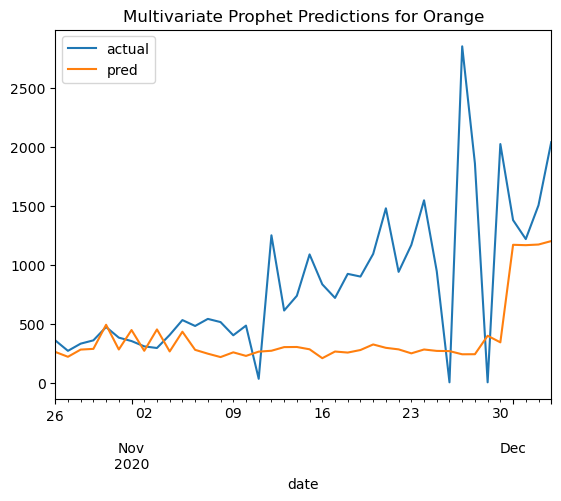

In [22]:
model=prophet.Prophet(holidays=events, holidays_prior_scale=0.1, changepoint_prior_scale=0.1, seasonality_prior_scale=0.01,
                                         seasonality_mode = 'additive',yearly_seasonality=True, weekly_seasonality=True)
model.add_country_holidays(country_name='US')
test.fillna(0, inplace=True)
train.fillna(0, inplace=True)
for ii in train.columns:
    if ii == 'index':
        continue
    if ii == 'ds':
        continue
    if ii == 'cases':
        continue
    if ii == 'y':
        continue
    model.add_regressor(ii)
model.fit(train)
pred = model.predict(test)


prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True), 
              'pred':pred.yhat.reset_index(drop = True)})
prediction['date'] = pd.to_datetime(test['ds'].reset_index(drop = True))
prediction.plot(x = 'date', y = ['actual', 'pred'], title='Multivariate Prophet Predictions for Orange')

In [23]:
mean_absolute_percentage_error(prediction[prediction['actual'] != 0].actual, prediction[prediction['actual'] != 0].pred)

8.885736405438